# CSCI E-81 HW5 - Partners: Piyawan Chirayus and Cindy Liu

<a id='imports'></a>
[Go to Table of Contents](#toc)

In [1152]:
import time
import re
import requests  # pip install requests
from bs4 import BeautifulSoup

%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
from pandas.tools.plotting import scatter_matrix

import sklearn
from sklearn import cluster, preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cindy.liu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


When VERBOSE is true you will get more detailed output in the data loading and data processing steps. Setting this to false will produce more concise output.

In [ ]:
VERBOSE = True

<a id='mpl-settings'></a>

In [ ]:
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap

dark2_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
set2_colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']

bold_colors = ['#FF0000', '#00FF00', '#FFAAAA', '#0000FF']
light_colors = ['#FFAAAA', '#AAFFAA', '#AAAAFF', '#00FF00']
cmap_light = ListedColormap(light_colors)
cmap_bold = ListedColormap(bold_colors)
dark2_cmap = ListedColormap(dark2_colors)
set2_cmap = ListedColormap(dark2_colors)
light_grey = np.array([float(248)/float(255)]*3)
shade_black = '#262626'

def set_mpl_params():
    rcParams['figure.figsize'] = (10, 6)
    rcParams['figure.dpi'] = 150
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 16
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

# Remove border function taken from CS109 2013 
######################################
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
def cible_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Make a target axis at 0,0 with ticks along the axis lines
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))

    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

<a id='plot-functions'></a>

In [ ]:
# Visualization functions stolen from section notebook

def plot_2D(groups, title):
    plt.figure(figsize=(10,6))
    for name, group in groups:
        plt.scatter(group.dimension1, group.dimension2, alpha = 0.6, s=30, label=cluster_names[name], 
                    facecolor=dark2_colors[name], edgecolor=shade_black, linewidth=0.35)
    plt.ylabel('2nd Dimension' )
    plt.xlabel('1st Dimension' )
    plt.title(title)
    #plt.gca().xaxis.grid(True)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.6, scatterpoints=1)
    rect = legend.get_frame()
    rect.set_facecolor(light_grey)
    rect.set_linewidth(0.6)
    plt.gca().grid(False)
    remove_border(top=False, right=False, left=True, bottom=True)
    plt.show()

def plot_3D(groups, title, elevation=15, azimuth=150):
    fig = plt.figure(figsize=(10,6))
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=elevation, azim=azimuth)
    for name, group in groups:
        ax.scatter(group.dimension1, group.dimension2, group.dimension3, alpha = 0.6, s=30, label=cluster_names[name], 
                    facecolor=dark2_colors[name], edgecolor=shade_black, linewidth=0.35)
    ax.set_zlabel('3rd Dimension' )
    ax.set_ylabel('2nd Dimension' )
    ax.set_xlabel('1st Dimension' )
    ax.set_title(title)
    legend = ax.legend(loc=3,frameon=True,framealpha=0.6, scatterpoints=1)
    rect = legend.get_frame()
    rect.set_facecolor(light_grey)
    rect.set_linewidth(0.2)
    plt.show()
    
def plot_2D_withlabels(df,groups, title):
    plt.figure(figsize=(10,6))
    for name, group in groups:
        plt.scatter(group.dimension1, group.dimension2, alpha = 0.6, s=30, label=cluster_names[name], 
                    facecolor=dark2_colors[name], edgecolor=shade_black, linewidth=0.35)
    for i in range(df.shape[0]):
        plt.text(df.ix[i]['dimension1'], df.ix[i]['dimension2'], df.ix[i]['title'], alpha = 0.8, color='grey', size=9)  
    plt.ylabel('2nd Dimension' )
    plt.xlabel('1st Dimension' )
    plt.title(title)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.6, scatterpoints=1)
    rect = legend.get_frame()
    rect.set_facecolor(light_grey)
    rect.set_linewidth(0.2)
    plt.gca().grid(False)
    remove_border(top=False, right=False, left=True, bottom=True)
    plt.show()

def make_plot_frame(proj, labels, cluster, title):
    get_shape = proj.shape[1]
    dimensions = ["Dimension"+str(i) for i in range(get_shape)]
    columns = ["dimension"+str(i+1) for i in range(get_shape)]
    columns.extend(["label", "cluster", "title"])
    data = np.column_stack((proj, labels, cluster, title))
    clustergroups = pd.DataFrame(data, columns = columns)
    return clustergroups

<a id='toc'></a>

## Table of Contents
- [Import statements](#imports)
- [Graphing settings](#mpl-settings)
- [Visualization functions from section notebook](#plot-functions)
- [Loading data](#loading-data)
- [Data processing](#data-processing)
- [Stemming](#stemming)
- [Feature extraction using TF-IDF](#tf-idf)
- [PCA](#pca)
- [MDS](#mds)
- [K-means clustering](#k-means)
- [Cluster visualization](#visual-1)
- [t-distributed SNE](#td-sne)
- [Analysis](#end)

<a id='loading-data'></a>
[Back to Table of Contents](#toc)

## Loading data

Loading the reference data provided with this homework:

In [493]:
ref = pd.read_table('Shakespeare_characters.txt', header=0, encoding='latin-1')
del ref['Unnamed: 1']
ref = ref.set_value((ref.Speaker == 'Lafew').argmax(), 'Speaker', 'Lafeu')
ref.Speaker = ref.Speaker.str.lower()  # for cross-referencing compatibility with names in the play texts
ref.head()

,Speaker,Gender,NumLines,Play,TopVillain,Fools
0,hamlet,Male,1506,Hamlet,NaN,NaN
1,iago,Male,1088,Othello,yes,NaN
2,king henry,Male,1031,Henry V,NaN,NaN
3,othello,Male,880,Othello,NaN,NaN
4,timon,Male,850,Timon of Athens,NaN,NaN


Getting the texts of all the plays by scraping the "Entire play in one page" pages:

In [492]:
BASE_URL = 'http://shakespeare.mit.edu/'

# Get main page
r = requests.get(BASE_URL)
assert(r.status_code == 200)

# Soupify main page and get table element
soup = BeautifulSoup(r.content, 'html.parser')
table = soup.find_all('table')[1]

# Scrape play titles from table element
titles = {}  # dict of plays and play data
num_titles = 0
if not VERBOSE:
    print('Getting documents', end='')
start = time.time()
for link in table.find_all('a'):
    # Skip poetry
    if 'Poetry' not in link.get('href'):
        if '\n' in link.string:
            link.string = link.string.replace('\n', ' ').strip()
        href = link.get('href').replace('index', 'full')
        # Taking advantage of their URL naming conventions
        send_url = BASE_URL + href
        if VERBOSE:
            print('Getting {} from {}'.format(link.string, send_url))
        else:
            print('.', end='')
        num_titles += 1
        # Get text of each play and add to dict of plays
        r = requests.get(send_url)
        assert(r.status_code == 200)
        # `titles` dict structure:
        titles[link.string] = {
            'href': href,
            'soup': BeautifulSoup(r.content, 'html.parser')
        }
end = time.time()
print('Done! Retrieved {} documents in {:.3f}s.'.format(num_titles, end - start))

Getting All's Well That Ends Well from http://shakespeare.mit.edu/allswell/full.html
Getting As You Like It from http://shakespeare.mit.edu/asyoulikeit/full.html
Getting The Comedy of Errors from http://shakespeare.mit.edu/comedy_errors/full.html
Getting Cymbeline from http://shakespeare.mit.edu/cymbeline/full.html
Getting Love's Labours Lost from http://shakespeare.mit.edu/lll/full.html
Getting Measure for Measure from http://shakespeare.mit.edu/measure/full.html
Getting The Merry Wives of Windsor from http://shakespeare.mit.edu/merry_wives/full.html
Getting The Merchant of Venice from http://shakespeare.mit.edu/merchant/full.html
Getting A Midsummer Night's Dream from http://shakespeare.mit.edu/midsummer/full.html
Getting Much Ado About Nothing from http://shakespeare.mit.edu/much_ado/full.html
Getting Pericles, Prince of Tyre from http://shakespeare.mit.edu/pericles/full.html
Getting Taming of the Shrew from http://shakespeare.mit.edu/taming_shrew/full.html
Getting The Tempest from 

<a id='data-processing'></a>
[Back to Table of Contents](#toc)

## Processing raw documents into data frame

In [884]:
COLUMN_NAMES = ['Title','Act','Scene','Speaker','Words']


# Given the data in the parameters, decides how to add the data to the data frame.
def add_data(df, title, act, scene, speaker, words):
    # Do we already have an entry for this speaker?
    if speaker in df.Speaker.values:
        # Get the row index of this speaker and add the new words to that speaker's existing words
        indices = list(df[df.Title == title][df.Act == act][df.Scene == scene][df.Speaker == speaker].index)
        if len(indices) == 1:
            index = indices[0]
            df.set_value(index, 'Words', df.Words[index] + ' ' + words)
            return df
        # In case of weird errors, but there should never be more than one row fitting above criteria
        elif len(indices) > 1:
            print(title, act, scene, speaker, indices)
            return df
    # If this is a totally new speaker, make a new row entry in the data frame for him/her
    new_row = pd.DataFrame([[title, act, scene, speaker, words]], columns=COLUMN_NAMES)
    df = df.append(new_row, ignore_index=True)
    return df


data = pd.DataFrame([], columns=COLUMN_NAMES)
num_processed = 0
if not VERBOSE:
    print('Processing documents', end='')

# For each play, iterate through each line of the play's html text sequentially,
#  tracking which act, scene, and speaker we're on. Whenever a new speaker
#  or a new scene/act arrives, take the words we've gathered for the last speaker
#  and add them to the data frame.
# The resulting table will contain 1 row for each unique combination of play,
#  act, scene, and speaker. Thus the words for each speaker are grouped by scene.
#        ** NB: This script ONLY scrapes character speeches - if
#        **     prologue material exists without a speaker specified
#        **     (i.e., "narrator" text), this script will ignore it.
start = time.time()
for title in titles:
    if VERBOSE:
        print(title)
    else:
        print('.', end='')
    # Skip to the first act - which is not always ACT I but sometimes PROLOGUE or even None
    act = titles[title]['soup'].find('h3')
    scene = speaker = words = ''
    # The rest of this is essentially just a big nested switch statement.
    if act.string[:3] != 'ACT':
        scene = act.string.split('.')[0]
        act.string = 'None'
    for elem in act.next_elements:
        if elem.name == 'h3':
            if words and speaker:
                data = add_data(data, title, act.string, scene, speaker, words)
                words = ''
            if elem.string[:3] == 'ACT':
                act = elem
            else:
                scene = elem.string.split('.')[0]
        if elem.name == 'a':
            if elem.attrs['name'][:6] == 'speech':
                if words and speaker:
                    data = add_data(data, title, act.string, scene, speaker, words)
                    words = ''
                speaker = elem.string.lower()
            else:
                if words and speaker:
                    words += ' ' + elem.string.strip()
                else:
                    words += elem.string.strip()
    num_processed += 1
end = time.time()
print('Done! Processed {} documents in {:.3f}s.'.format(num_processed, end - start))

Coriolanus


/Users/cindy.liu/Desktop/cindy/e81/e81-venv/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Measure for Measure
Richard II
Cymbeline
King Lear
Timon of Athens
All's Well That Ends Well
The Tempest
Two Gentlemen of Verona
Henry VI, part 3
Henry VIII
Richard III
Romeo and Juliet
The Merry Wives of Windsor
Hamlet
Henry IV, part 2
As You Like It
Henry IV, part 1
Taming of the Shrew
Troilus and Cressida
Titus Andronicus
Love's Labours Lost
Othello
The Merchant of Venice
Pericles, Prince of Tyre
Henry V
Macbeth
A Midsummer Night's Dream
Henry VI, part 2
Henry VI, part 1
Winter's Tale
King John
Julius Caesar
The Comedy of Errors
Much Ado About Nothing
Twelfth Night
Antony and Cleopatra
Done! Processed 37 documents.


Here we're removing all punctuation to make things simpler. We're leaving apostrophes in because Shakespeare had a known penchant for using apostrophes to stylistically shorten words, so when we replace the apostrophes with spaces there are a lot more word fragments in the feature set.

We are also making all the character names lowercase because it's inconsistent across plays (some of them would have "Hamlet" while others would have "HAMLET" and so on). We made all the character names in the reference data frame lowercase as well, so that they would actually be able to align.

Lastly, to facilitate cross-referencing with the reference data, we're "fixing" a few of the titles that are the same but written differently.

In [919]:
data.Words = data.Words.str.replace("[^a-zA-Z']", " ")
data.Words = data.Words.str.lower()

translation = {
    "Henry IV, part 1": "Henry IV Part 1",
    "Henry IV, part 2": "Henry IV Part 2",
    "Henry VI, part 1": "Henry VI Part 1",
    "Henry VI, part 2": "Henry VI Part 2",
    "Henry VI, part 3": "Henry VI Part 3",
    "Love's Labours Lost": "Love's Labour's Lost",
    "Pericles, Prince of Tyre": "Pericles",
    "Taming of the Shrew": "The Taming of the Shrew",
    "Two Gentlemen of Verona": "The Two Gentlemen of Verona",
    "Winter's Tale": "The Winter's Tale"
}
# df.set_value(index, 'Words', df.Words[index] + ' ' + words)
changed = []
for row in data.index:
    if data.Title[row] in translation:
        data.set_value(row, 'Title', translation[data.Title[row]])
        if data.Title[row] not in changed:
            changed.append(data.Title[row])
print('Corrected following titles:', changed)

print('DataFrame dimensions:', data.shape)
print('Reference dimensions:', ref.shape)
data.head(15)

Corrected following titles: []
DataFrame dimensions: (3969, 5)
Reference dimensions: (1533, 6)


,Title,Act,Scene,Speaker,Words
0,Coriolanus,ACT I,SCENE I,first citizen,before we proceed any further hear me speak ...
1,Coriolanus,ACT I,SCENE I,all,speak speak resolved resolved we know't w...
2,Coriolanus,ACT I,SCENE I,second citizen,one word good citizens would you proceed esp...
3,Coriolanus,ACT I,SCENE I,menenius,what work's my countrymen in hand where go ...
4,Coriolanus,ACT I,SCENE I,marcius,thanks what's the matter you dissentious rog...
5,Coriolanus,ACT I,SCENE I,messenger,where's caius marcius the news is sir the v...
6,Coriolanus,ACT I,SCENE I,first senator,marcius 'tis true that you have lately told u...
7,Coriolanus,ACT I,SCENE I,cominius,you have fought together it is your former pr...
8,Coriolanus,ACT I,SCENE I,titus,no caius marcius i'll lean upon one crutch a...
9,Coriolanus,ACT I,SCENE I,sicinius,was ever man so proud as is this marcius when...


<a id='stemming'></a>
[Back to Table of Contents](#toc)

## Stemming

We tested a few stemmers including the standard Porter stemmer here, and we decided to leave open the option of using no stemming as well.

In [788]:
porter = PorterStemmer()
lancaster = LancasterStemmer()
snowball = SnowballStemmer('english')

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

def tokenizer_lancaster(text):
    return [lancaster.stem(word) for word in text.split()]

def tokenizer_snowball(text):
    return [snowball.stem(word) for word in text.split()]

def tokenizer_vanilla(text):
    return [word for word in text.split()]

print(tokenizer_porter('It was a bright cold day in April and the clocks were striking thirteen'))
print(tokenizer_lancaster('It was a bright cold day in April and the clocks were striking thirteen'))
print(tokenizer_snowball('It was a bright cold day in April and the clocks were striking thirteen'))
print(tokenizer_vanilla('It was a bright cold day in April and the clocks were striking thirteen'))

['It', 'wa', 'a', 'bright', 'cold', 'day', 'in', 'April', 'and', 'the', 'clock', 'were', 'strike', 'thirteen']
['it', 'was', 'a', 'bright', 'cold', 'day', 'in', 'april', 'and', 'the', 'clock', 'wer', 'striking', 'thirteen']
['it', 'was', 'a', 'bright', 'cold', 'day', 'in', 'april', 'and', 'the', 'clock', 'were', 'strike', 'thirteen']
['It', 'was', 'a', 'bright', 'cold', 'day', 'in', 'April', 'and', 'the', 'clocks', 'were', 'striking', 'thirteen']


<a id='tf-idf'></a>
[Back to Table of Contents](#toc)

## Feature extraction using TF-IDF

All very standard using the default values for the most part.

In [983]:
all_stopwords = stopwords.words('english')
all_stopwords.append('\'')  # this is to prevent having a feature consisting of a single apostrophe

In [992]:
start = time.time()
vectorizer = TfidfVectorizer(tokenizer = tokenizer_snowball,
                             stop_words=all_stopwords,
                             use_idf=True,
                             max_features = 250,ngram_range=(1,1))
train_data_features = vectorizer.fit_transform(data.Words.values)
end = time.time()
train_data_features = train_data_features.A
vocab = vectorizer.get_feature_names()
print('Runtime {:.3f}s'.format(end - start))

Runtime 12.177s


In [993]:
df = pd.DataFrame(data=train_data_features,columns=vocab)
print(df.shape)
df.head()

(3969, 250)


,ani,anoth,answer,arm,art,asid,away,ay,back,bear,...,wit,within,without,woman,word,world,would,wrong,yet,young
0,0.119768,0.000000,0.280853,0.141371,0.000000,0.000000,0.000000,0.061157,0.000000,0.061651,...,0.0,0.0,0.0,0.0,0.058095,0.000000,0.135879,0.0,0.098463,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.557674,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.247978,0.000000,0.193334,0.0,0.000000,0.0
3,0.000000,0.000000,0.068982,0.069446,0.061145,0.000000,0.000000,0.000000,0.073247,0.060570,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.096736,0.0
4,0.065386,0.081091,0.000000,0.000000,0.067954,0.087119,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.063432,0.069244,0.296726,0.0,0.000000,0.0


<a id='pca'></a>
[Back to Table of Contents](#toc)

## PCA

In [1151]:
def PCA(label,features=100,tokenizer = tokenizer_vanilla):
    all_stopwords = stopwords.words('english')
    vectorizer = TfidfVectorizer(tokenizer = tokenizer_vanilla,
                                 stop_words=all_stopwords,
                                 use_idf=False,
                                 max_features = features,
                                 ngram_range=(1,1))
    train_data_features = vectorizer.fit_transform(data.Words.values)
    train_data_features = train_data_features.A
    vocab = vectorizer.get_feature_names()
    df = pd.DataFrame(data=train_data_features,columns=vocab)

    dropvalue = ['Speaker', 'Gender', 'NumLines', 'Play', 'TopVillain', 'Fools']
    dropvalue.remove(label)

    df_copy = df.copy()
    df_speaker = pd.concat([data['Speaker'],df_copy], axis=1)
    df_scaled = pd.merge(ref, df_speaker, on='Speaker', how='left')
    df_scaled.drop(dropvalue, axis=1, inplace=True)
    df_scaled.columns = df_scaled.columns.str.replace('Unnamed: 0',label)
    # df_scaled = df_scaled.dropna()
    df_scaled.dropna(inplace=True)
    df_scaled.reset_index(drop=True, inplace=True)
    df_scaled.iloc[:,1:] = preprocessing.StandardScaler().fit_transform(df_scaled.iloc[:,1:])


    pca = sklearn.decomposition.PCA(n_components=4).fit(df_scaled.iloc[:,1:])

    coef_PCA = pca.transform(df_scaled.iloc[:,1:])
    print("Principal component shape using : ",coef_PCA.shape)
    # Scree plot to see how many Principal Components to consider
    plt.figure(figsize=(12, 6))        
    eig = pca.explained_variance_      # Eigenvalue 

    # Calculate the variance explained by the PC analysis
    var_exp = pca.explained_variance_ratio_.cumsum()*100.

    plt.plot(np.arange(1,len(eig)+1), eig, color='r')
    plt.title('Scree plot for the PCA')
    plt.xlabel('Number of principal components')
    plt.ylabel('Eigenvalues')
    remove_border()
    plt.show()

    print ('The 1st Principal Component explains {:03.1f} % of the variance\n'.format(var_exp[0]))
    print ('The 1st and 2nd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[1]))
    print ('The 1st, 2nd and 3rd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[2]))
    print ('The first four Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[3]))

    plt.figure(figsize=(10,6))
    plt.scatter(coef_PCA[:,0], coef_PCA[:,1], s = 70, zorder=0, c=dark2_colors[0])
    for i in range(coef_PCA.shape[0]):
        plt.text(coef_PCA[i,0]+.1, coef_PCA[i,1], df_scaled.ix[i][label],  zorder=1, size=12, color=shade_black)  
    plt.ylabel('2nd Principal component' )
    plt.xlabel('1st Principal component' )
    plt.title('PC2 vs. PC1')
    remove_border()
    plt.show()
    
    fig = plt.figure(1, figsize=(10, 8))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=15, azim=150)
    plt.cla()

    ax.scatter(coef_PCA[:,0], coef_PCA[:,1], coef_PCA[:,2], s = 130, zorder=0, c=dark2_colors[0])
    for i in range(coef_PCA.shape[0]):
        ax.text(coef_PCA[i,0], coef_PCA[i,1], coef_PCA[i,2], df_scaled.ix[i][label], zorder=1, size=12, color=shade_black) 

    ax.set_xlabel('1st Principal component')
    ax.set_ylabel('2nd Principal component')
    ax.set_zlabel('3rd Principal component')
    ax.set_title('1st, 2nd and 3rd Principal Components')
    plt.show()
    
    scatter_matrix(pd.DataFrame(coef_PCA), alpha=0.7, figsize=(12, 12),  diagonal='kde')
    plt.show()

Principal component shape using :  (9785, 4)


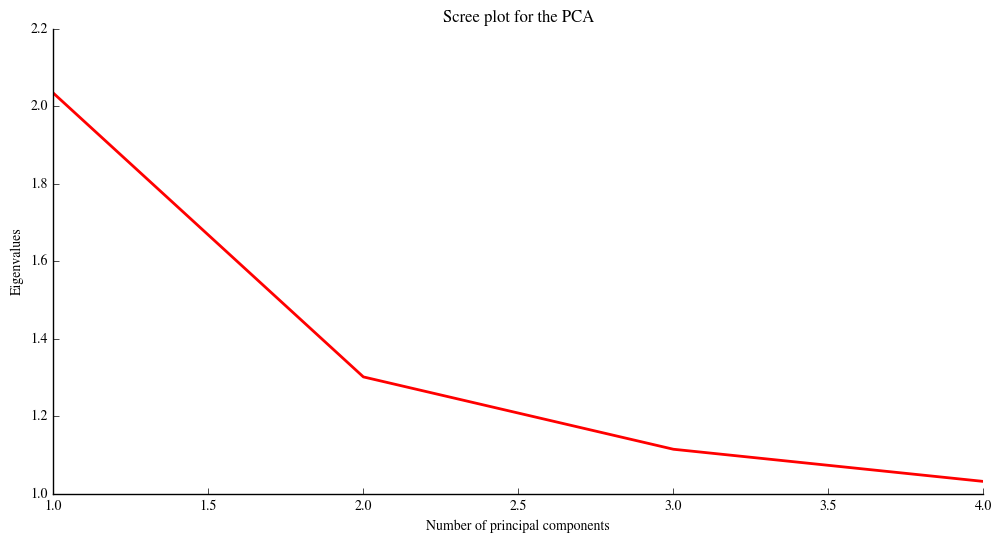

The 1st Principal Component explains 20.3 % of the variance

The 1st and 2nd Principal Components explain 33.4 % of the variance

The 1st, 2nd and 3rd Principal Components explain 44.5 % of the variance

The first four Principal Components explain 54.8 % of the variance



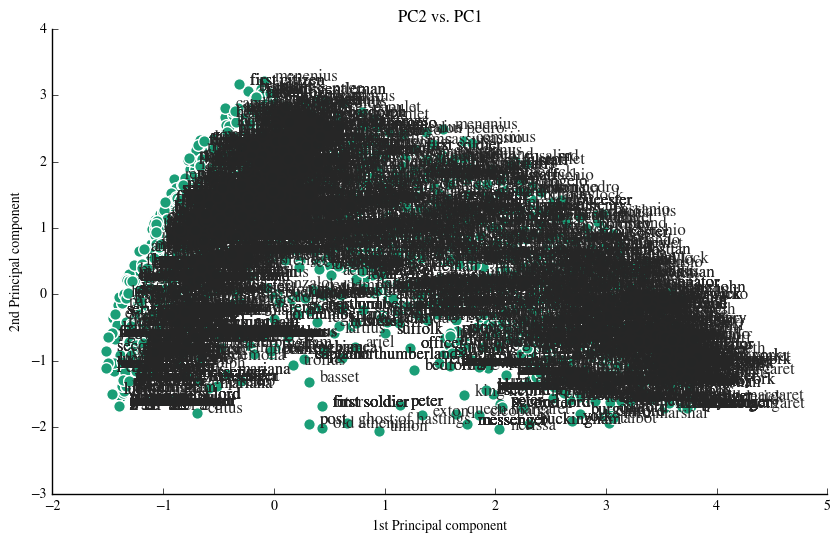

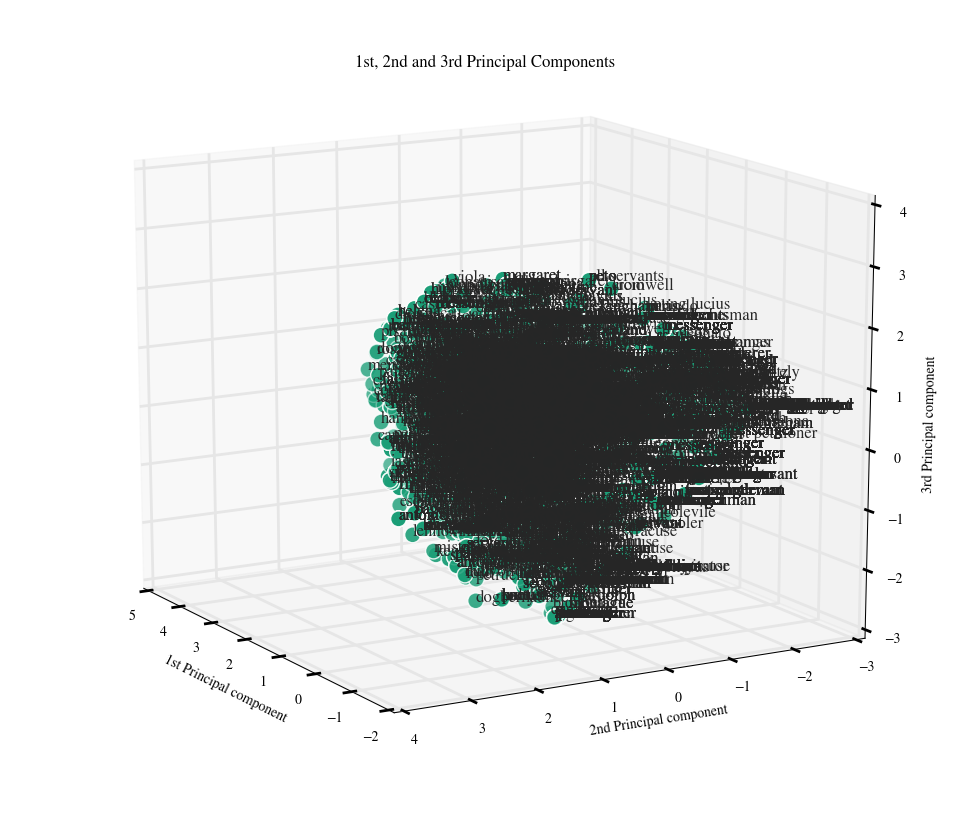

In [1134]:
start = time.time()
PCA('Speaker',10,'tokenizer_porter')
end = time.time()
print('Runtime {:.3f}s'.format(end - start))

Principal component shape using :  (9785, 4)


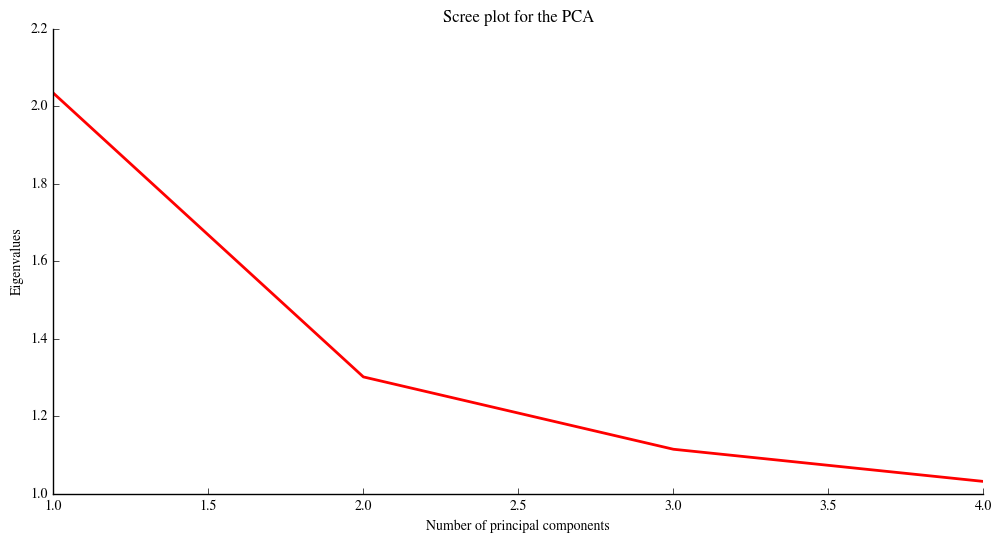

The 1st Principal Component explains 20.3 % of the variance

The 1st and 2nd Principal Components explain 33.4 % of the variance

The 1st, 2nd and 3rd Principal Components explain 44.5 % of the variance

The first four Principal Components explain 54.8 % of the variance



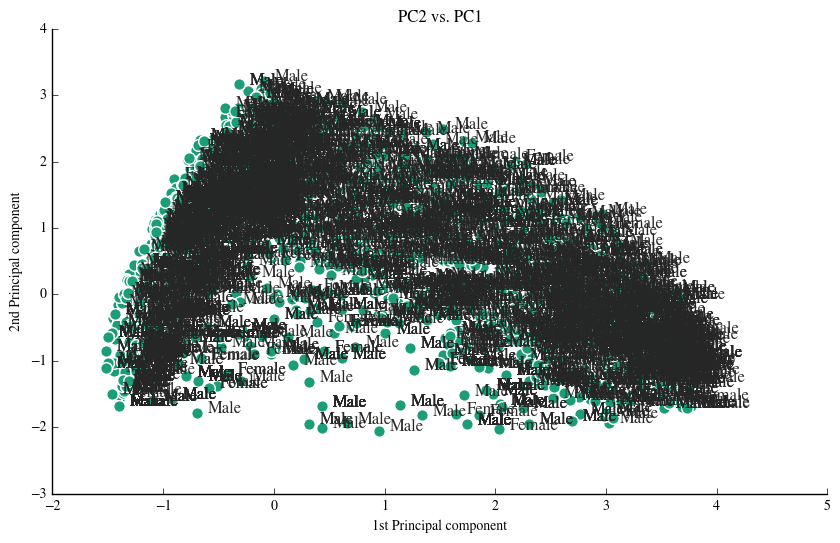

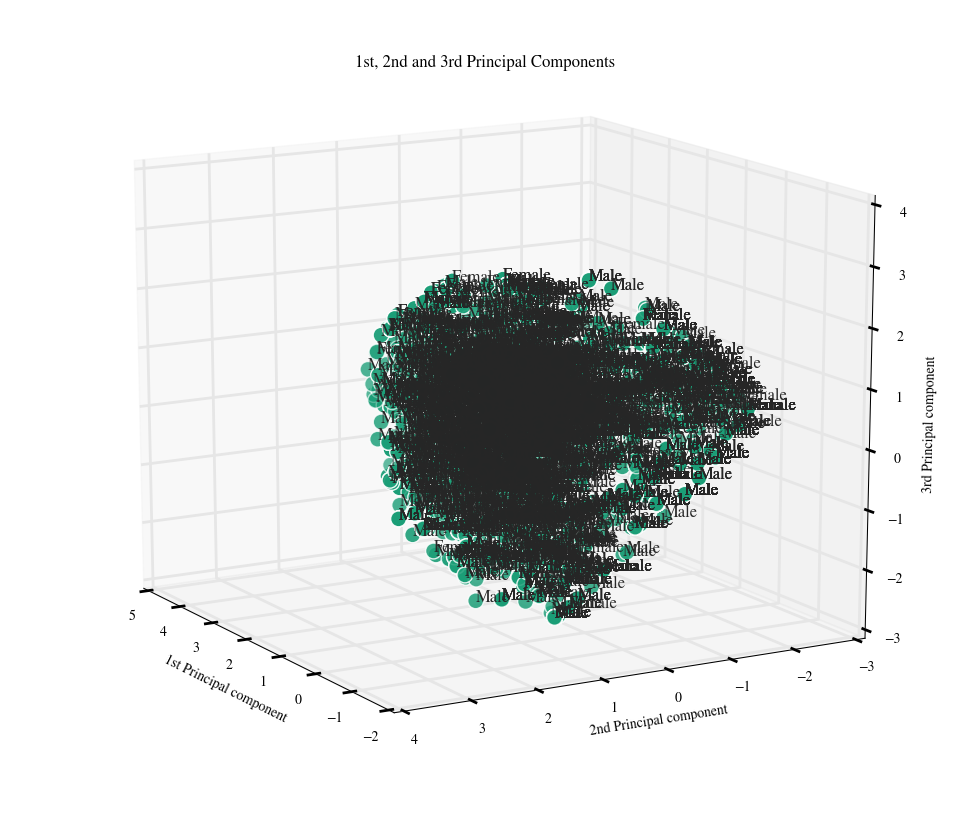

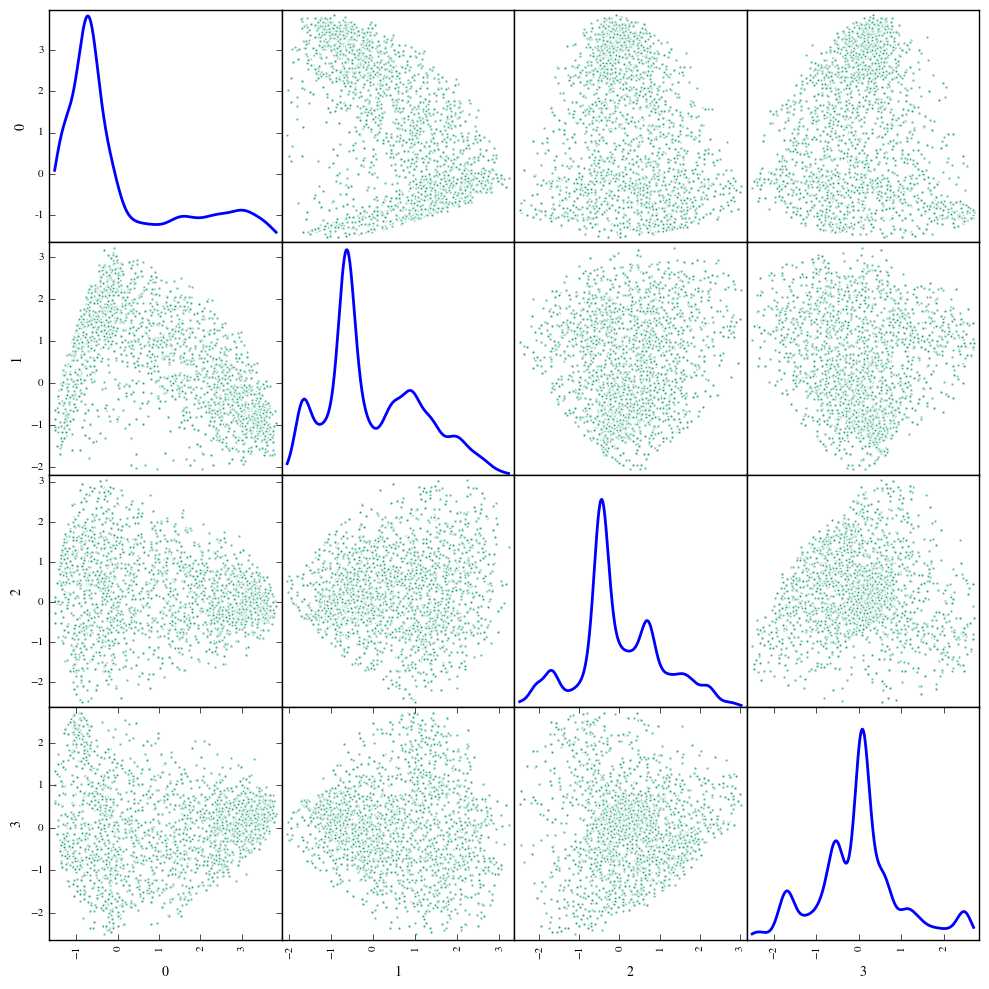

Runtime 61.454s


In [1153]:
start = time.time()
PCA('Gender',10,'tokenizer_porter')
end = time.time()
print('Runtime {:.3f}s'.format(end - start))

In [ ]:
start = time.time()
PCA('NumLines',10,'tokenizer_porter')
end = time.time()
print('Runtime {:.3f}s'.format(end - start))

In [ ]:
start = time.time()
PCA('Play',10,'tokenizer_porter')
end = time.time()
print('Runtime {:.3f}s'.format(end - start))

<a id='mds'></a>
[Back to Table of Contents](#toc)

## MDS

Calculations for the MDS visualization in the [Cluster visualization](#visual-1) section below.

In [994]:
CS_dist = 1 - cosine_similarity(train_data_features)
Euclid_dist = euclidean_distances(train_data_features)
print(Euclid_dist.shape, CS_dist.shape)

(3969, 3969) (3969, 3969)


In [995]:
start = time.time()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=99)
text_MDS = mds.fit_transform(CS_dist)  # shape (n_components, n_samples)
text_MDS.shape
end = time.time()
print('Runtime {:.3f}s'.format(end - start))

Runtime 641.745s


<a id='k-means'></a>
[Back to Table of Contents](#toc)

## K-means clustering

K was pretty much determined by manually trying a range from 2-10 and eyeballing the results. We tried this range for k to do the analysis on the TF-IDF matrix generated a variety of ways (different stemmer, different number of features, etc.), and we found the clearest results to be with k=4 or k=5 pretty consistently.

In [1037]:
cluster_names = {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6', 7: 'C7', 8: 'C8', 9: 'C9'}
MAX_CLUSTERS = 5
kmeans = KMeans(init='k-means++', n_clusters=MAX_CLUSTERS, n_init=10)
kmeans.fit(train_data_features)
df['KM_cluster'] = kmeans.predict(train_data_features)
df['KM_cluster'].replace(cluster_names, inplace=True)

In [1038]:
print("\nTotal number of clusters and composition: ")
print (df['KM_cluster'].value_counts()[::-1])
print("\nSilhouette Coefficient: %0.3f"
      % metrics.silhouette_score(train_data_features, kmeans.labels_, sample_size=1000))


Total number of clusters and composition: 
C0     343
C2     376
C4     731
C3    1101
C1    1418
Name: KM_cluster, dtype: int64

Silhouette Coefficient: 0.028


<a id='visual-1'></a>
[Back to Table of Contents](#toc)

## Cluster visualization

In [1040]:
df.loc[:,'SpeakerIndex'] = data.index.values
df.head()

,ani,anoth,answer,arm,art,asid,away,ay,back,bear,...,without,woman,word,world,would,wrong,yet,young,KM_cluster,SpeakerIndex
0,0.119768,0.000000,0.280853,0.141371,0.000000,0.000000,0.000000,0.061157,0.000000,0.061651,...,0.0,0.0,0.058095,0.000000,0.135879,0.0,0.098463,0.0,C3,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.557674,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,C1,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.247978,0.000000,0.193334,0.0,0.000000,0.0,C3,2
3,0.000000,0.000000,0.068982,0.069446,0.061145,0.000000,0.000000,0.000000,0.073247,0.060570,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.096736,0.0,C3,3
4,0.065386,0.081091,0.000000,0.000000,0.067954,0.087119,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.063432,0.069244,0.296726,0.0,0.000000,0.0,C3,4


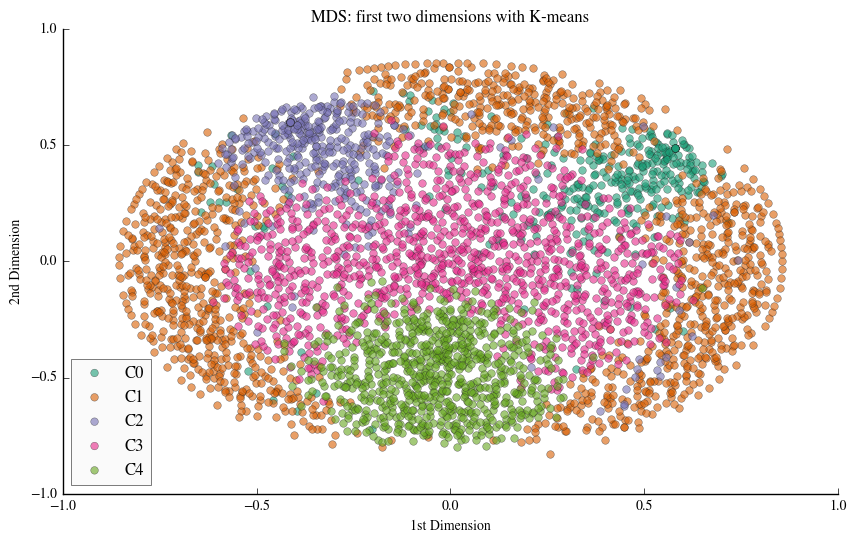

In [1041]:
dark2_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666', '#2966ab', '#66ff33']

df1 = make_plot_frame(text_MDS, kmeans.labels_, df.loc[:,"KM_cluster"],df.loc[:,"SpeakerIndex"])
clusterGroups = df1.groupby('label')

# Plot the features with MDS  
plot_2D(clusterGroups, 'MDS: first two dimensions with K-means')  

<a id='td-sne'></a>
[Back to Table of Contents](#toc)

## t-distributed Stochastic Neighbor Embedding

The documentation on TruncatedSVD recommends using 100 components for text data, so that's what we're using here. We played around with the TSNE parameters a bit, switching algorithms from Barnes-Hut (the default) to the "exact" method which I'm not really familiar with the details on, but it's supposed to be more accurate at the expense of taking longer.

In [1044]:
start = time.time()
X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(train_data_features)
X_embedded = TSNE(n_components=3, perplexity=25, verbose=0).fit_transform(X_reduced)
end = time.time()
print('Runtime {:.3f}s'.format(end - start))

Runtime 76.909s


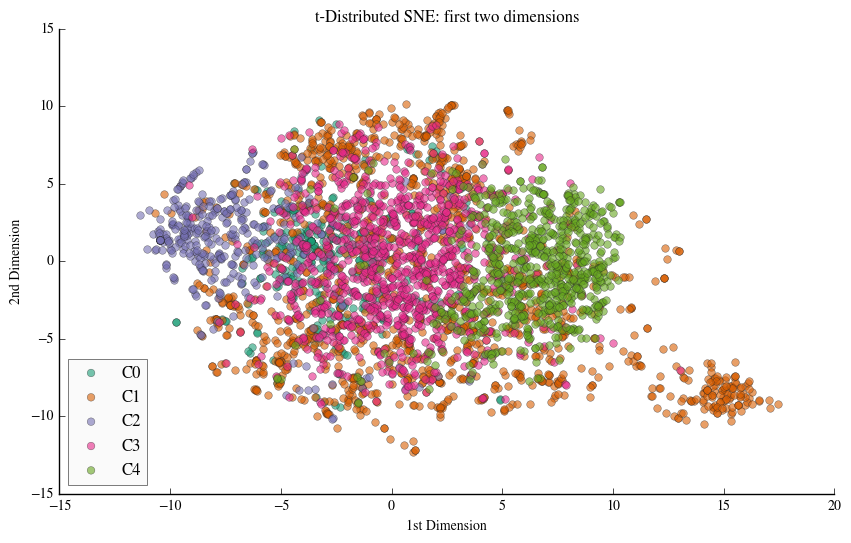

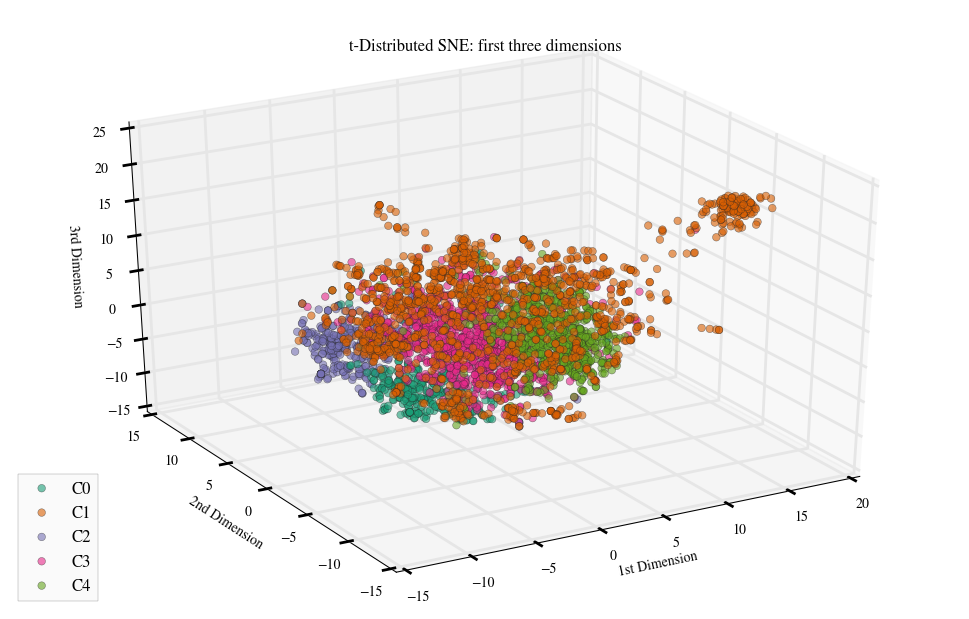

In [1045]:
df2 = make_plot_frame(X_embedded, kmeans.labels_, df.loc[:,"KM_cluster"],df.loc[:,"SpeakerIndex"])
clusterGroups = df2.groupby('label')

plot_2D(clusterGroups, 't-Distributed SNE: first two dimensions')
plot_3D(clusterGroups, 't-Distributed SNE: first three dimensions', 30, 240)

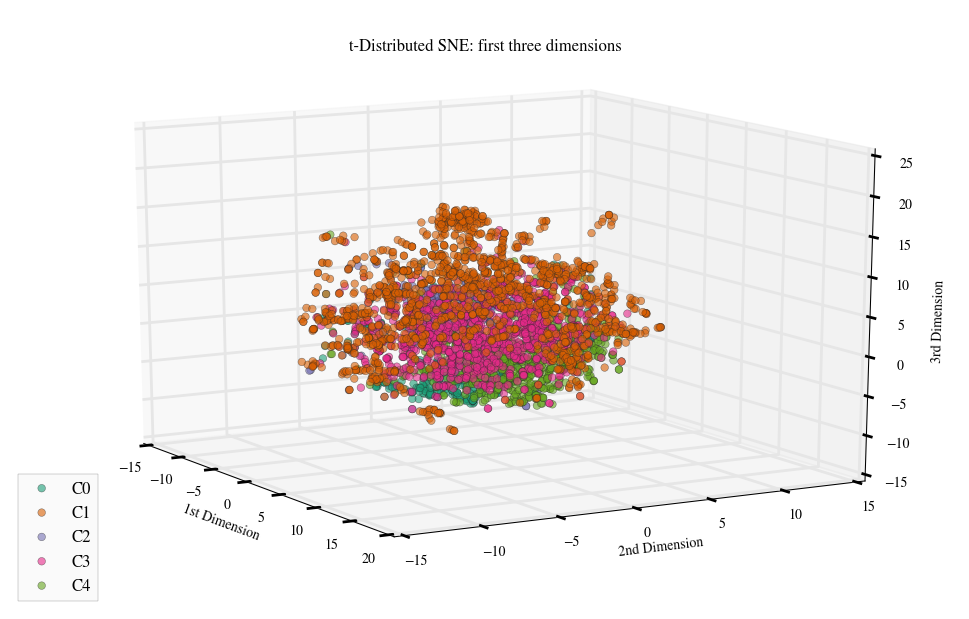

In [1046]:
plot_3D(clusterGroups, 't-Distributed SNE: first three dimensions', 15, 330)

<a id='end'></a>
[Back to Table of Contents](#toc)

## Analysis

It's incomplete; ran out of time to get the simple histogram at the end running (it's commented out).

The next few steps are all to merge our dataset with the clusters and reference dataset.

In [1047]:
data['KM_cluster'] = df['KM_cluster']
data.head()

,Title,Act,Scene,Speaker,Words,KM_cluster
0,Coriolanus,ACT I,SCENE I,first citizen,before we proceed any further hear me speak ...,C3
1,Coriolanus,ACT I,SCENE I,all,speak speak resolved resolved we know't w...,C1
2,Coriolanus,ACT I,SCENE I,second citizen,one word good citizens would you proceed esp...,C3
3,Coriolanus,ACT I,SCENE I,menenius,what work's my countrymen in hand where go ...,C3
4,Coriolanus,ACT I,SCENE I,marcius,thanks what's the matter you dissentious rog...,C3


To simplify things greatly, we're only looking at the union of our dataset and the reference dataset based on play and speaker.

In [1099]:
r = set(ref.Speaker + ',' + ref.Play)
d = set(data.Speaker + ',' + data.Title)
print(ref.shape, data.shape)
union = d.intersection(r)
d_not_r = d.difference(r)
r_not_d = r.difference(d)
print(len(r), len(d), len(union), len(d_not_r), len(r_not_d))

(1533, 6) (3969, 6)
1533 1341 1062 279 471


In [1147]:
indices = []
for x in union:
    spk, ttl = x.split(',')
    indices += list(data.loc[data.Speaker == spk][data.Title == ttl].index.values)
joint_df = data.loc[indices]
# joint_df.sort(['Title', 'Speaker', 'Act', 'Scene'], inplace=True)
# ref.sort(['Play', 'Speaker'], inplace=True)

/Users/cindy.liu/Desktop/cindy/e81/e81-venv/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [1148]:
print(len(indices))
print(joint_df.shape)
joint_df.head()

3152
(3152, 6)


,Title,Act,Scene,Speaker,Words,KM_cluster
591,Timon of Athens,ACT I,SCENE I,first lord,what time o' day is't apemantus that time se...,C1
595,Timon of Athens,ACT I,SCENE II,first lord,my lord we always have confess'd it might we...,C2
644,Timon of Athens,ACT III,SCENE VI,first lord,the good time of day to you sir upon that we...,C3
911,Henry VI Part 3,ACT I,SCENE I,edward,lord stafford's father duke of buckingham is...,C1
923,Henry VI Part 3,ACT I,SCENE II,edward,no i can better play the orator no quarrel ...,C1


Sloppy merging:

In [1149]:
gender = []
numLines = []
topVillain = []
fools = []
for row in joint_df.index.values:
    ttl = joint_df.Title.loc[row]
    spk = joint_df.Speaker.loc[row]
    i = ref.loc[ref.Play == ttl][ref.Speaker == spk].index
    gender.append(ref.Gender.loc[i].values[0])
    numLines.append(ref.NumLines.loc[i].values[0])
    topVillain.append(ref.TopVillain.loc[i].values[0])
    fools.append(ref.Fools.loc[i].values[0])

/Users/cindy.liu/Desktop/cindy/e81/e81-venv/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [1150]:
joint_df['Gender'] = gender
joint_df['NumLines'] = numLines
joint_df['TopVillain'] = topVillain
joint_df['Fools'] = fools
joint_df.head()

,Title,Act,Scene,Speaker,Words,KM_cluster,Gender,NumLines,TopVillain,Fools
591,Timon of Athens,ACT I,SCENE I,first lord,what time o' day is't apemantus that time se...,C1,Male,21,NaN,NaN
595,Timon of Athens,ACT I,SCENE II,first lord,my lord we always have confess'd it might we...,C2,Male,21,NaN,NaN
644,Timon of Athens,ACT III,SCENE VI,first lord,the good time of day to you sir upon that we...,C3,Male,21,NaN,NaN
911,Henry VI Part 3,ACT I,SCENE I,edward,lord stafford's father duke of buckingham is...,C1,Male,428,NaN,NaN
923,Henry VI Part 3,ACT I,SCENE II,edward,no i can better play the orator no quarrel ...,C1,Male,428,NaN,NaN


Initial foray into plotting....something. Anything. Ran out of time, sorry. This is commented out because it does not work.

In [1162]:
# x = np.array(list(joint_df.Gender.loc[joint_df.KM_cluster == 'C0'].values))

# n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)
# l = plt.plot(bins, y, 'r--', linewidth=1)

# plt.xlabel('')
# plt.ylabel('')
# plt.title('')
# # plt.axis([40, 160, 0, 0.03])
# plt.grid(True)

# plt.show()